# Testing Different ML Algorithms
Just getting an idea for what would be effective with this dataset

In [1]:
%matplotlib inline
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import cross_validate, cross_val_predict, RepeatedKFold, GridSearchCV
from sklearn.linear_model import BayesianRidge, ARDRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
import warnings; warnings.simplefilter('ignore')

## Load in the Dataset
This was created by a different notebook

In [3]:
data = pd.read_csv('training_set.csv')

Determine which columns are inputs

In [4]:
charge_attrs = [x for x in data.columns if x.startswith('charge')]

In [5]:
agni_attrs = [x for x in data.columns if x.startswith('AGNI')]

In [6]:
ewald_attrs = ['ewald_force',]

In [7]:
y_col = 'force'

In [8]:
X_cols = charge_attrs + agni_attrs + ewald_attrs

## Test out Some ML Models
Trying out various differentiable ML algorithms:

- `DummyRegressor`: 
- `BayesianRidge`: Ridge regression that sets the hyperparameters for you
- ~~`ARDRegression`: Sparser BayesianRidge~~ [Too slow]
- `MLPRegressor`: Simple NN, annoying to tune
- ~~`GuassianProcessRegressor`: Nonlinear continuous model~~ [Too slow]
- `Lasso`: Sparse linear model, fast to train

### Create Testing Routines
Some tools used to test this model

In [9]:
kfold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1) # 10x10-fold CV

In [10]:
def train_over_time(model, data, steps=None):
    """Train the model on increasingly-larger amounts of data
    
    :param model: model to be tested
    :param data: training/test data
    :param steps: increments to test at. Model is trained at all entries before this timestep
    :return: 
        - train_size: Number of training points
        - average_force: Average force (i.e., stopping power) as at each step
        - trajectory: Full trajectory
        - step: timestep
    """
    
    # Get the default steps
    if steps is None:
        steps = np.linspace(data['timestep'].min(), data['timestep'].max(), 31, dtype=np.int)[1:]
        
    # Test the models
    mean_forces = []
    trajs = []
    force_errors = []
    train_size = []
    for step in steps:
        # Train model on all timesteps before current
        train_data = data.query('timestep <= %d'%step)
        train_size.append(len(train_data))
        model.fit(train_data[X_cols], train_data[y_col])
        
        
        # Predict on all timesteps
        traj = model.predict(data[X_cols])
        
        # Store results
        mean_forces.append(traj.mean())
        trajs.append(traj)
        force_errors.append((traj - data[y_col]).mean())
    
    return train_size, mean_forces, trajs, steps

In [11]:
test_results = dict()
def run_tests(model, name, verbose=False):
    """Evaluate a model, store results in test_results variable
    
    :param model: model to test
    :param name: name of results to store"""
    
    # Standard cross-validation
    k_fold = cross_validate(model, data[charge_attrs+agni_attrs+ewald_attrs].values, data[y_col].values,
               scoring='neg_mean_squared_error', cv=kfold)
    if verbose:
        print('Model: %s - K-fold error: mean=%.2e max=%.2e'%(name, -k_fold['test_score'].mean(), -k_fold['test_score'].min()))
        
    # Increase time CV
    step, mean_forces, traj, steps = train_over_time(model, data)
    
    if verbose:
        print('Model: %s - Stopping power after half simulation: predicted=%.2f actual=%.2f'%(name,
                                                                                              mean_forces[int(len(mean_forces)/2)],
                                                                                             data[y_col].mean()))
    
    test_results[name] = {
        'k_fold':k_fold,
        'over_time': {'training_size': step, 'mean_force': mean_forces, 'traj': traj, 'step':steps}
    }

### Run a dummy model
Get a "non-ML" baseline

In [12]:
model = DummyRegressor()

In [13]:
%%time
run_tests(model, 'dummy', True)

Model: dummy - K-fold error: mean=2.25e+01 max=5.38e+01
Model: dummy - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 200 ms


### Test default NN
Get a baseline for the later tuning

In [14]:
model = MLPRegressor(activation='tanh', hidden_layer_sizes=(16,))

In [15]:
model

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [16]:
%%time
run_tests(model, 'baseline_nn', True)

Model: baseline_nn - K-fold error: mean=3.06e-01 max=8.32e-01
Model: baseline_nn - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 1min 23s


### Test Bayesian Ridge


In [17]:
model = BayesianRidge(normalize=True)

In [18]:
%%time
run_tests(model, 'bayes', True)

Model: bayes - K-fold error: mean=2.53e-03 max=2.81e-03
Model: bayes - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 538 ms


#### Measure Feature Importances

In [19]:
model.fit(data[X_cols], data[y_col])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False)

In [20]:
pd.DataFrame({'feature':X_cols, 'weight':model.coef_})

,feature,weight
0,charge_t=1.00,-0.004648
1,charge_t=0.00,0.005188
2,charge_t=-1.00,-0.004830
3,charge_t=-2.00,-0.002318
4,charge_t=-3.00,0.003309
5,charge_t=-4.00,-0.003345
6,charge_t=-5.00,0.017968
7,AGNI_eta=1.04e+01,7883.339253
8,AGNI_eta=1.23e+00,43.147236
9,AGNI_eta=1.60e+01,-3730.328798


### Test Bayesian Ridge w/ Poly Features

In [21]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', BayesianRidge())
])

In [22]:
%%time
run_tests(model, 'bayes_poly', True)

Model: bayes_poly - K-fold error: mean=4.56e-04 max=6.18e-04
Model: bayes_poly - Stopping power after half simulation: predicted=0.25 actual=0.24
Wall time: 13.6 s


### Lasso

In [23]:
model = GridSearchCV(Lasso(normalize=True, max_iter=5000, fit_intercept=True), {'alpha':np.logspace(-7,-1,20)}, cv=2)

In [24]:
%%time
run_tests(model, 'lasso', True)

Model: lasso - K-fold error: mean=9.58e-03 max=1.33e-02
Model: lasso - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 1min 50s


#### Measure Feature Importances

In [25]:
model.fit(data[X_cols], data[y_col])

GridSearchCV(cv=2, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-07,   2.06914e-07,   4.28133e-07,   8.85867e-07,
         1.83298e-06,   3.79269e-06,   7.84760e-06,   1.62378e-05,
         3.35982e-05,   6.95193e-05,   1.43845e-04,   2.97635e-04,
         6.15848e-04,   1.27427e-03,   2.63665e-03,   5.45559e-03,
         1.12884e-02,   2.33572e-02,   4.83293e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [26]:
model.best_estimator_.alpha

3.3598182862837813e-05

In [27]:
pd.DataFrame({'feature':X_cols, 'weight':model.best_estimator_.coef_})

,feature,weight
0,charge_t=1.00,0.002508
1,charge_t=0.00,-0.000000
2,charge_t=-1.00,0.000000
3,charge_t=-2.00,0.000000
4,charge_t=-3.00,-0.007060
5,charge_t=-4.00,0.000000
6,charge_t=-5.00,0.008862
7,AGNI_eta=1.04e+01,0.000000
8,AGNI_eta=1.23e+00,10.713093
9,AGNI_eta=1.60e+01,0.000000


*Finding*: Charge density is not important. Also, AGNI fingerprints do not carry velocity information

## Plot the Results

Mean absolute error of the force averaged across the entire trajectory

In [28]:
experiment_number = 14

print('Training set size: ', test_results['dummy']['over_time']['training_size'][experiment_number])
results = dict([
    (name, {'force_mae': np.abs(data[y_col] - my_data['over_time']['traj'][experiment_number]).mean(),
            'mean_force_error': data[y_col].mean() - my_data['over_time']['mean_force'][experiment_number]})
    for name, my_data in test_results.items()
])
over_time_results = pd.DataFrame(results).T
over_time_results

Training set size:  4725


,force_mae,mean_force_error
baseline_nn,0.199689,-0.033275
bayes,0.038306,0.002211
bayes_poly,0.051495,-0.003498
dummy,0.715687,0.001903
lasso,0.053780,0.001021


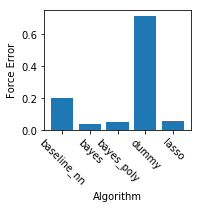

In [29]:
fig, ax = plt.subplots()

ax.bar(range(len(over_time_results)), over_time_results['force_mae'])

ax.set_xticks(range(len(over_time_results)))
ax.set_xticklabels(list(over_time_results.index), fontsize=10, rotation=-45);

ax.set_ylabel('Force Error')
ax.set_xlabel('Algorithm', fontsize=10)

fig.set_size_inches(2.9, 3)
fig.tight_layout()

fig.savefig('ml_algorithm_error.pdf')
fig.savefig('ml_algorithm_error.png', dpi=320)

Stopping power as a function of training set size. Black line is the known average

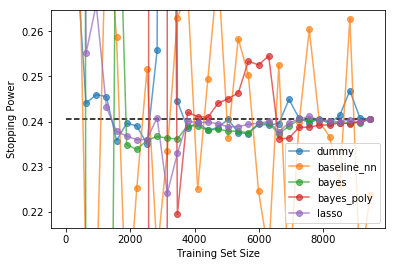

In [30]:
fig, ax = plt.subplots()

ax.plot([0,data['timestep'].max() - data['timestep'].min()], [data['force'].mean(),]*2, 'k--')

for name, my_data in test_results.items():
    ax.plot(my_data['over_time']['training_size'], my_data['over_time']['mean_force'], marker='o', label=name, alpha=0.7)
    
ax.set_ylim(data['force'].mean() * 0.9, data['force'].mean() * 1.1)

ax.legend()

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Stopping Power')

*Finding*: Bayesian linear regression seems to work the best

*To Do*: 
- Get Bayesian linear regression confidence intervals
- Incorporate velocity-dependent attributes. Only charge density is dependent
    - Or, switch to use recurrant models
- Figure out scaling on ARDRegression (want Lasso with confidence intervals)

## Plot just the best one: BayesRidge

In [31]:
def scale_force(x, exag=3):
    return np.sign(x) * np.power(np.abs(x), 1./exag) 
def unscale_force(x, exag=3):
    return np.sign(x) * np.abs(np.power(x, exag))

In [32]:
best_results = test_results['bayes']
num_tests = len(best_results['over_time']['traj'])

Plot the convergence of the stopping power

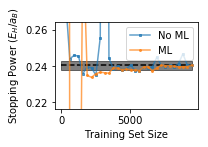

In [33]:
fig, ax = plt.subplots()

ax.plot([0,data['timestep'].max() - data['timestep'].min()], [data['force'].mean(),]*2, 'k--')#, label='Known Value')

ax.fill_between([0, data['timestep'].max() - data['timestep'].min()],
                [data['force'].mean() * 1.01, data['force'].mean() * 1.01],
                [data['force'].mean() * 0.99, data['force'].mean() * 0.99], color='k', alpha=0.5)

ax.plot(test_results['dummy']['over_time']['training_size'],
        test_results['dummy']['over_time']['mean_force'], marker='s', ms=2, alpha=0.7, label='No ML')
ax.plot(best_results['over_time']['training_size'], best_results['over_time']['mean_force'], 
        marker='o', ms=2, alpha=0.7, label='ML')
    
ax.set_ylim(data['force'].mean() * 0.9, data['force'].mean() * 1.1)

ax.legend()

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Stopping Power ($E_H/a_B$)')

fig.set_size_inches(3, 2)

fig.tight_layout()
fig.savefig('stopping_power_bayes.pdf')
fig.savefig('stopping_power_bayes.png', dpi=320)

Plot the force error as a function of training set size

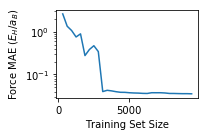

In [34]:
fig, ax = plt.subplots()


mae = [ np.abs(data['force'] - t).mean() for t in best_results['over_time']['traj'] ] 

ax.semilogy(best_results['over_time']['training_size'], mae)
    
    
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Force MAE ($E_H/a_B$)')

fig.set_size_inches(3, 2)

fig.tight_layout()
fig.savefig('mae_training_size.pdf')
fig.savefig('mae_training_size.png', dpi=320)

Plot how well the algorithm forecasts stopping force

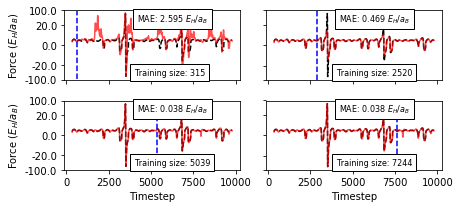

In [35]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


for f,ax in zip([0,int(0.25*num_tests),int(0.5*num_tests),int(0.75*num_tests)],axs.flatten()):
    
    ax.plot(data['timestep'], scale_force(data['force']), 'k--')
    ax.set_ylim(ax.get_ylim()) # Make sure the scales stay appropriate
    
    traj = best_results['over_time']['traj'][f]
    ax.plot(data['timestep'], scale_force(traj), 'r-', alpha=0.7)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(4200, scale_force(30), 'MAE: %.3f $E_H/a_B$'%traj_error, fontsize=8,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.text(4000, -4, 'Training size: %d'%best_results['over_time']['training_size'][f],
            fontsize=8,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.plot([best_results['over_time']['step'][f],]*2, ax.get_ylim(), 'b--')

axs[1,0].set_xlabel('Timestep')
axs[1,1].set_xlabel('Timestep')
axs[0,0].set_ylabel('Force ($E_H/a_B$)')
axs[1,0].set_ylabel('Force ($E_H/a_B$)')

# Unscale force
y_ticks = [-100, -20, 0, 20, 100]
axs[0,0].set_yticks(scale_force(y_ticks))
axs[0,0].set_yticklabels(['%.1f'%f for f in y_ticks])
axs[1,0].set_yticks(scale_force(y_ticks))
axs[1,0].set_yticklabels(['%.1f'%f for f in y_ticks])

fig.set_size_inches(6.5,3)
fig.tight_layout()
fig.savefig('ml_over_time.pdf')
fig.savefig('ml_over_time.png', dpi=320)

## TBD: Compute Stopping Power on Different Path